# Exercício 1 - Projeto 1 - Lógica Computacional

## 1. Abordagem utilizada para resolver o problema

1. Utilização das bibliotecas OR-TOOLS e NetworkX

In [27]:
# Importação da biblioteca NetworkX
import networkx as nx
# Importação da biblioteca OR-Tools
from ortools.linear_solver import pywraplp

2. Criação do grafo com **"edges"** bidirecionais, com 13 nodos: 
   - 3 nodos de fornecimento (**"sources"**)
     - S1, S2, S3
   - 6 nodos de pontos de passagem
     - P1, P2, P3, P4, P5, P6
   - 4 nodos de pontos de entrega (**"sinks"**)
     - E1, E2, E3, E4

In [28]:

G = nx.Graph()
arestas = [
    ("S1","P1",4), ("S1","P2",2), ("S2","P2",3), ("S2","P3",2),
    ("S3","P4",3), ("P1","P5",2), ("P2","P5",2), ("P3","P6",2),
    ("P4","P6",2), ("P5","E1",3), ("P5","E2",2), ("P6","E2",2),
    ("P6","E3",2), ("P5","P6",4),("P6","E4",2)   
]
for u,v,c in arestas:
    G.add_edge(u, v, cap=c)

SOURCES = {
    "S1": {"stock": 18, "max_veiculos": 3},
    "S2": {"stock": 23, "max_veiculos": 4},
    "S3": {"stock": 25, "max_veiculos": 5}
}

ENCOMENDAS = {
    "E1": {"1u":4, "2u":2, "5u":1},   # 13 unidades
    "E2": {"1u":5, "2u":3, "5u":2},   # 21 unidades
    "E3": {"1u":2, "2u":1, "5u":1},   # 9 unidades
    "E4": {"1u": 3, "2u": 2}          # 7 unidades
}

capacidade_veiculo = 10
TIPOS_ENCOMENDAS = {"1u":1, "2u":2, "5u":5}

Representação ilustrativa do grafo

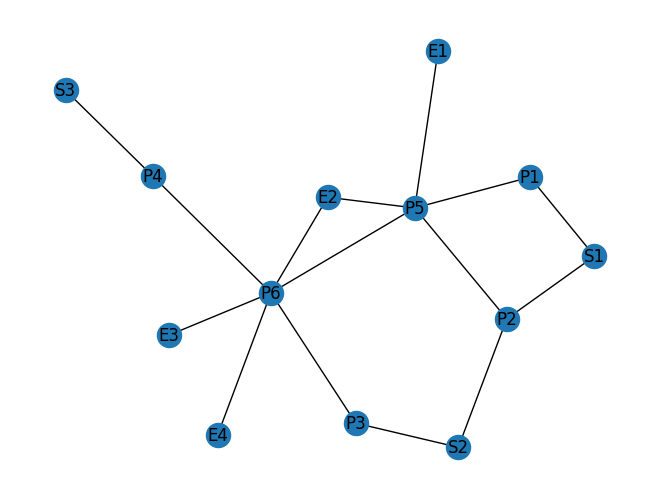

In [29]:
nx.draw(G, with_labels=True)

3. Criar a instância do solver

In [30]:
solver = pywraplp.Solver.CreateSolver('SCIP')
#Criar dicionários, quais veículos vão para quais encomendas e quantos pacotes cada veículo carrega para cada encomenda
x, y = {}, {}

Criar as combinações possiveis de pontos de fornecimento, de entrega, veículos disponveis em cada fornecimento e tipo de pacotes:

In [31]:
for f in SOURCES:
    for e in ENCOMENDAS:
        for i in range(SOURCES[f]["max_veiculos"]):  
            x[f,e,i] = solver.BoolVar(f'x_{f}_{e}_{i}')
            for t in TIPOS_ENCOMENDAS:
                y[f,e,i,t] = solver.IntVar(0, ENCOMENDAS[e].get(t,0), f'y_{f}_{e}_{i}_{t}')

Restrições:

$$
\forall f \in S, \forall e \in E, \forall i \in \{0, 1, \dots, \text{max\_veiculos}_f - 1\}\quad
\sum_{t \in T} y_{f,e,i,t} \leq \text{capacidade\_veiculo} \cdot x_{f,e,i}
$$
Garante que a soma das unidades transportadas não ultrapassa a capacidade máxima do veículo:

In [32]:
for f in SOURCES:
    for e in ENCOMENDAS:
        for i in range(SOURCES[f]["max_veiculos"]):
            solver.Add(
                sum(y[f,e,i,t]*TIPOS_ENCOMENDAS[t] for t in TIPOS_ENCOMENDAS) 
                <= capacidade_veiculo * x[f,e,i])

$$
\forall f \in S \quad
\sum_{e \in E} \sum_{i=0}^{\text{max\_veiculos}_f - 1} \sum_{t \in T} y_{f,e,i,t} \cdot u_t
\leq \text{stock}_f
$$
Garante que não ultrapassamos o stock disponível pelo fornecedor:

In [33]:
for f in SOURCES:
    solver.Add(
        sum(y[f,e,i,t]*TIPOS_ENCOMENDAS[t] for e in ENCOMENDAS for i in range(SOURCES[f]["max_veiculos"]) for t in TIPOS_ENCOMENDAS)
        <= SOURCES[f]["stock"])

$$
\forall e \in E, \forall t \in T \quad
\sum_{f \in S} \sum_{i=0}^{\text{max\_veiculos}_f - 1} y_{f,e,i,t} = \text{pedido}_{e,t}
$$

Garante que todas as unidades da encomenda são entregues no respetivo ponto de entrega:

In [34]:
for e in ENCOMENDAS:
    for t in TIPOS_ENCOMENDAS:
        solver.Add(
            sum(y[f,e,i,t] for f in SOURCES for i in range(SOURCES[f]["max_veiculos"])) 
            == ENCOMENDAS[e].get(t,0))

Pretendemos minimizar o número de veículos. Para isso, definimos:

$$
\text{total\_veiculos} = \sum_{f \in S} \sum_{e \in E} \sum_{i=0}^{\text{max\_veiculos}_f - 1} x_{f,e,i}
$$


Atribuimos a restricão total_veiculos ao solver de forma a encontrar a melhor solução usando o **menor número possível de veículos**:


In [35]:
total_veiculos = solver.Sum(x[f,e,i] for f in SOURCES for e in ENCOMENDAS for i in range(SOURCES[f]["max_veiculos"]))
solver.Minimize(total_veiculos)

A função def_paths remove os nodos que não são de passagem e usamos a função nx.shortest_simple_paths para criar os possíveis caminhos do ponto de fornecimento(origem) para o ponto de entrega(destino):

In [36]:
def get_paths(G, origem, destino, K=4):
    G_tmp = G.copy()
    for sink in ENCOMENDAS: 
        if sink != destino and sink in G_tmp :
            G_tmp.remove_node(sink)
    for f in SOURCES:
        if f != origem and f in G_tmp:
            G_tmp.remove_node(f)
    try:
        return list(nx.shortest_simple_paths(G_tmp, origem, destino))[:K]
    except nx.NetworkXNoPath:
        return []

Invocamos o solver e verificamos as soluções que são válidas,  para construir o output com a informação sobre o veículo, encomenda, quantidade de unidades transportadas pelo veículo:

In [37]:
status = solver.Solve()
if status in [pywraplp.Solver.OPTIMAL, pywraplp.Solver.FEASIBLE]:
    G_aux = G.copy()

    for f in SOURCES:
        for i in range(SOURCES[f]["max_veiculos"]):
            usado = False
            for e in ENCOMENDAS:
                num_encomenda = e.replace("E", "") 
                if x[f,e,i].solution_value() > 0.5:
                    rotas = get_paths(G_aux, f, e, K=4)
                    encontrou = False
                    for rota in rotas:
                        if all(G_aux[u1][u2]['cap'] >= 1 for u1,u2 in zip(rota[:-1], rota[1:])):
                            for u1,u2 in zip(rota[:-1], rota[1:]):
                                G_aux[u1][u2]['cap'] -= 1
                            pacotes = {t: int(y[f,e,i,t].solution_value()) for t in TIPOS_ENCOMENDAS if y[f,e,i,t].solution_value() > 0}
                            print(f"Veículo {i} de {f} para encomenda {num_encomenda}: {pacotes}, rota: {rota}")
                            usado = True
                            encontrou = True
                            break
                    if not encontrou:
                        print(f"Veículo {i} de {f} para a encomenda {num_encomenda}: vias cheias.")
                        usado = True
            if not usado:
                print(f"Veículo {i} de {f} não foi usado")
else:
    print("Inválido.")

Veículo 0 de S1 para encomenda 3: {'1u': 2, '2u': 1, '5u': 1}, rota: ['S1', 'P1', 'P5', 'P6', 'E3']
Veículo 0 de S1 para encomenda 4: {'1u': 3, '2u': 2}, rota: ['S1', 'P1', 'P5', 'P6', 'E4']
Veículo 1 de S1 não foi usado
Veículo 2 de S1 não foi usado
Veículo 0 de S2 para encomenda 2: {'1u': 1}, rota: ['S2', 'P2', 'P5', 'E2']
Veículo 1 de S2 para encomenda 1: {'1u': 3, '2u': 1}, rota: ['S2', 'P2', 'P5', 'E1']
Veículo 1 de S2 para encomenda 2: {'1u': 4, '2u': 3}, rota: ['S2', 'P3', 'P6', 'E2']
Veículo 2 de S2 não foi usado
Veículo 3 de S2 não foi usado
Veículo 0 de S3 para encomenda 1: {'1u': 1, '2u': 1, '5u': 1}, rota: ['S3', 'P4', 'P6', 'P5', 'E1']
Veículo 0 de S3 para encomenda 2: {'5u': 2}, rota: ['S3', 'P4', 'P6', 'E2']
Veículo 1 de S3 não foi usado
Veículo 2 de S3 não foi usado
Veículo 3 de S3 não foi usado
Veículo 4 de S3 não foi usado


## 2. Exemplos Práticos

Dados de um grafo com 4 nodos: 
   - 1 nodo de fornecimento (**"sources"**)
     - S1
   - 1 nodos de pontos de passagem:
     - P1
   - 2 nodos de pontos de entrega (**"sinks"**):
     - E1, E2

In [38]:
G = nx.Graph()
arestas = [
    ("S1","P1",5),
    ("P1","E1",3),
    ("P1","E2",4)
]
for u,v,c in arestas:
    G.add_edge(u, v, cap=c)

SOURCES = {
    "S1": {"stock": 10, "max_veiculos": 2}  
}

ENCOMENDAS = {
    "E1": {"1u":2, "2u":1},   # 4 unidades
    "E2": {"1u":3, "2u":1}    # 5 unidades
}
TIPOS_ENCOMENDAS = {"1u":1, "2u":2, "5u":5}  
capacidade_veiculo = 10

**Output esperado:**

Veículo 0 de S1 para encomenda 1: {'1u': 2, '2u': 1}, rota: ['S1', 'P1', 'E1']

Veículo 0 de S1 para encomenda 2: {'1u': 3, '2u': 1}, rota: ['S1', 'P1', 'E2']

Veículo 1 de S1 não foi usado

Dados de um grafo com 20 nodos: 
   - 4 nodos de fornecimento (**"sources"**):
     - S1, S2, S3, S4
   - 10 nodos de pontos de passagem:
     - P1, P2, P3, P4, P5, P6, P7, P8, P9, P10
   - 6 nodos de pontos de entrega (**"sinks"**):
     - E1, E2, E3, E4, E5, E6

In [39]:
G = nx.Graph()

arestas = [
    ("S1","P1",12), ("S1","P2",10),
    ("S2","P2",12), ("S2","P3",10),
    ("S3","P3",12), ("S3","P4",10),
    ("S4","P4",10), ("S4","P5",12),
    ("P1","P6",10), ("P2","P6",9), ("P2","P7",10),
    ("P3","P7",9), ("P3","P8",10), ("P4","P8",12),
    ("P5","P9",10), ("P6","P10",9), ("P7","P10",10),
    ("P8","P10",10), ("P9","P10",12),
    ("P10","E1",12), ("P10","E2",10), ("P9","E3",9),
    ("P8","E4",12), ("P7","E5",10), ("P6","E6",10)
]


for u,v,c in arestas:
    G.add_edge(u, v, cap=c)

SOURCES = {
    "S1": {"stock": 60, "max_veiculos": 6},
    "S2": {"stock": 55, "max_veiculos": 5},
    "S3": {"stock": 65, "max_veiculos": 6},
    "S4": {"stock": 50, "max_veiculos": 5}
}

ENCOMENDAS = {
    "E1": {"1u": 6, "2u": 3, "5u": 1},   # 17 unidades
    "E2": {"1u": 7, "2u": 2, "5u": 1},   # 16 unidades
    "E3": {"1u": 5, "2u": 4, "5u": 2},   # 23 unidades
    "E4": {"1u": 4, "2u": 3, "5u": 1},   # 15 unidades
    "E5": {"1u": 7, "2u": 2, "5u": 2},   # 21 unidades
    "E6": {"1u": 3, "2u": 2}             # 7 unidades
}

capacidade_veiculo = 10

TIPOS_ENCOMENDAS = {"1u":1, "2u":2, "5u":5}

**Output esperado:**

Veículo 0 de S1 para encomenda 3: {'2u': 1, '5u': 1}, rota: ['S1', 'P1', 'P6', 'P10', 'P9', 'E3']

Veículo 0 de S1 para encomenda 4: {'1u': 1, '2u': 2, '5u': 1}, rota: ['S1', 'P1', 'P6', 'P10', 'P8', 'E4']

Veículo 0 de S1 para encomenda 5: {'1u': 6, '2u': 2}, rota: ['S1', 'P2', 'P7', 'E5']

Veículo 1 de S1 para encomenda 1: {'1u': 6, '2u': 2}, rota: ['S1', 'P1', 'P6', 'P10', 'E1']

Veículo 1 de S1 para encomenda 3: {'1u': 5, '5u': 1}, rota: ['S1', 'P1', 'P6', 'P10', 'P9', 'E3']

Veículo 1 de S1 para encomenda 5: {'1u': 1}, rota: ['S1', 'P2', 'P7', 'E5']

Veículo 2 de S1 para encomenda 3: {'2u': 3}, rota: ['S1', 'P1', 'P6', 'P10', 'P9', 'E3']

Veículo 2 de S1 para encomenda 4: {'1u': 3, '2u': 1}, rota: ['S1', 'P1', 'P6', 'P10', 'P8', 'E4']

Veículo 3 de S1 não foi usado

Veículo 4 de S1 não foi usado

Veículo 5 de S1 não foi usado

Veículo 0 de S2 para encomenda 1: {'2u': 1, '5u': 1}, rota: ['S2', 'P2', 'P6', 'P10', 'E1']

Veículo 0 de S2 para encomenda 2: {'1u': 2, '2u': 1, '5u': 1}, rota: ['S2', 'P2', 'P6', 'P10', 'E2']

Veículo 0 de S2 para encomenda 5: {'5u': 2}, rota: ['S2', 'P2', 'P7', 'E5']

Veículo 0 de S2 para encomenda 6: {'1u': 3, '2u': 2}, rota: ['S2', 'P2', 'P6', 'E6']

Veículo 1 de S2 para encomenda 2: {'1u': 5, '2u': 1}, rota: ['S2', 'P2', 'P6', 'P10', 'E2']

Veículo 2 de S2 não foi usado

Veículo 3 de S2 não foi usado

Veículo 4 de S2 não foi usado

Veículo 0 de S3 não foi usado

Veículo 1 de S3 não foi usado

Veículo 2 de S3 não foi usado

Veículo 3 de S3 não foi usado

Veículo 4 de S3 não foi usado

Veículo 5 de S3 não foi usado

Veículo 0 de S4 não foi usado

Veículo 1 de S4 não foi usado

Veículo 2 de S4 não foi usado

Veículo 3 de S4 não foi usado

Veículo 4 de S4 não foi usado
